In [127]:
%matplotlib widget
import matplotlib.pyplot as plt
import math
import random

# FRESNEL

- An Inexpensive BRDF Model for Physically-based Rendering - Christophe Schlick
- depending on needs the function can be tailored to more accurate calculations
- using here a very computational inexpensive solution

In [128]:
def schlickFresnel(cosine: float, ior: float) -> float:
    r0 = (1-ior) / (1+ior)
    r0 = r0*r0
    return r0 + (1-r0)*(1-cosine)**5

In [129]:
def dielectricFresnel(cosine: float, ior: float) -> float:
    costhetaI = cosine

    if costhetaI < 0:
        costhetaI = -costhetaI
        ior = 1 / ior

    sin2thetaI = (1 - costhetaI * costhetaI)
    sin2thetaT = sin2thetaI / (ior*ior)

    if sin2thetaT > 1:
        return 1

    cos2thetaT = math.sqrt(1 - sin2thetaT)
    rp = (costhetaI - ior * cos2thetaT) / (costhetaI + ior * cos2thetaT)
    rs = (ior * costhetaI - cos2thetaT) / (ior * costhetaI + cos2thetaT)

    return 0.5 * (rp * rp + rs * rs)


In [130]:
angleMax = int(math.degrees(math.pi / 2))
angles = [math.radians(i) for i in range(0, angleMax)]

sFresnel = [schlickFresnel(math.cos(i), 1.02) for i in angles]
dFresnel = [dielectricFresnel(math.cos(i), 1.02) for i in angles]

x = [angles]
f = [sFresnel, dFresnel]
labels=["Schlick", "Dielectric"]


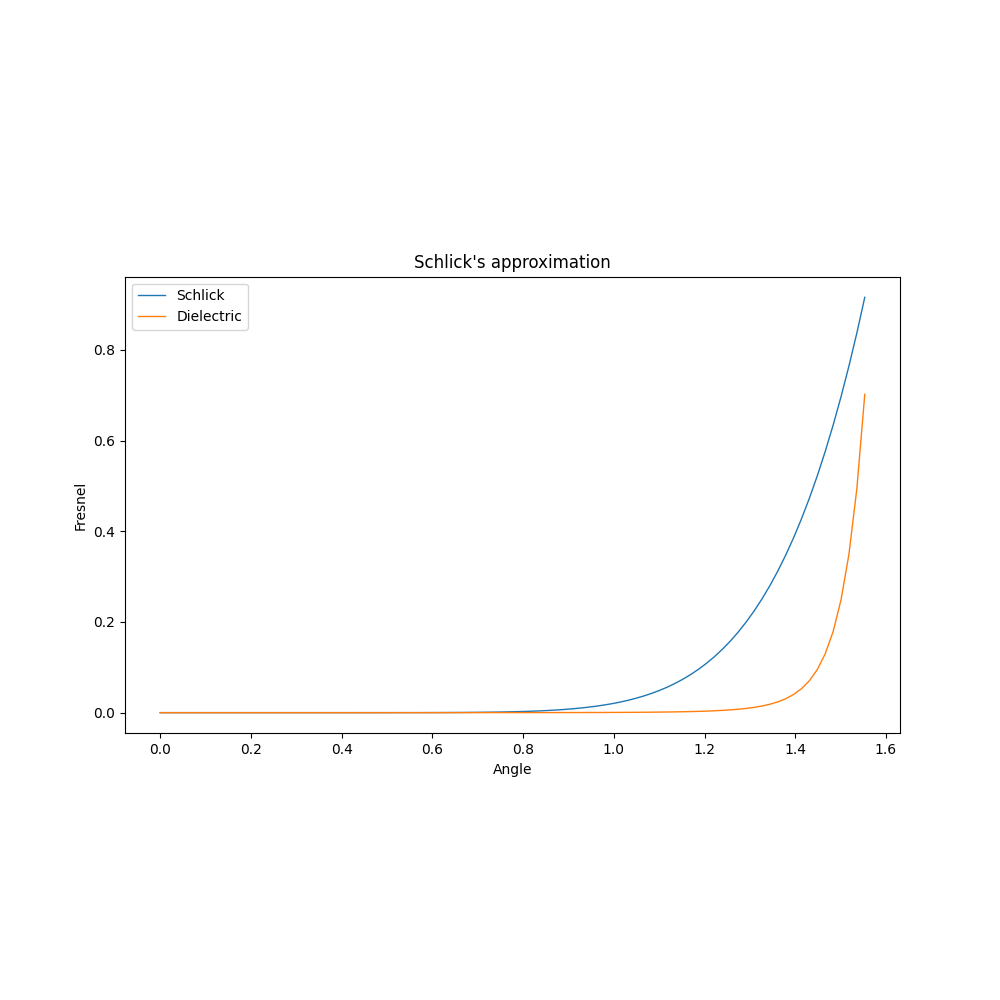

In [131]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(aspect='equal', adjustable='box')
ax.set_title("Schlick's approximation")
ax.set_xlabel("Angle")
ax.set_ylabel("Fresnel")

for i in range(len(f)):
    ax.plot(x[0], f[i], linewidth=1, label=labels[i])

ax.legend()
ax.autoscale(enable=True, axis='x', tight=False)
ax.autoscale(enable=True, axis='y', tight=False)
plt.show()

# GENERALIZED-TROWBRIDGE-REITZ

- Disney BRDF notes 2012 - Burley
- has long tails and short peaks in the distribution curve
- allows for normalisation and importance sampling
- Disney uses two fix specular lobes with gamma = [1, 2]
- alpha = roughness^2 result in better linearity

In [132]:
def roughnessToAlpha(roughness: float) -> float:
    r: float = roughness * roughness
    if r < 1e-4:
        return 1e-4
    return r

In [133]:
# theta in radians, roughness to alpha
def gtr(thetaH: float, alpha: float, gamma: int) -> float:
    costhetaH: float = math.cos(thetaH)
    sinthetaH: float = math.sin(thetaH)
    alpha2: float = alpha * alpha
    return 1 / (alpha2 * costhetaH * costhetaH + sinthetaH * sinthetaH)**gamma

In [134]:
# theta in radians, roughness to alpha
# derived from gtr
def gtr1(thetaH: float, alpha: float) -> float:
    if alpha >= 1:
        return 1 / math.pi
    cosThetaH = math.cos(thetaH)
    alpha2: float = alpha * alpha
    t: float = 1 + (alpha2 - 1) * cosThetaH * cosThetaH
    return (alpha2 - 1) / (math.pi * math.log(alpha2) * t) 


In [135]:
# theta in radians, roughness to alpha
# derived from gtr
def gtr2(thetaH: float, alpha: float) -> float:
    cosThetaH = math.cos(thetaH)
    alpha2: float = alpha * alpha
    t: float = 1 + (alpha2 - 1) * cosThetaH * cosThetaH
    return alpha2 / (math.pi * t * t)

In [136]:
def normalDistribution(x: list) -> list:
    return [i / max(x) for i in x]

In [137]:
# list comprehension fill list with values
ALPHA_MIN = 1e-4
ALPHA_MAX = 1
alpha = 0.2

thetasdeg = [i / 3 for i in range(0, int(math.degrees(math.pi / 2) + 1)) ]
thetas = [math.radians(i) for i in thetasdeg]

dist1 = [gtr1(t, alpha) for t in thetas]
dist2 = [gtr2(t, alpha) for t in thetas]
dist10 = [gtr(t, alpha, 10) for t in thetas]

dist1 = normalDistribution(dist1)
dist2 = normalDistribution(dist2)
dist10 = normalDistribution(dist10)

x = [thetas]
f = [dist1, dist2, dist10]
labels=["gtr1", "gtr2", "gtr10"]


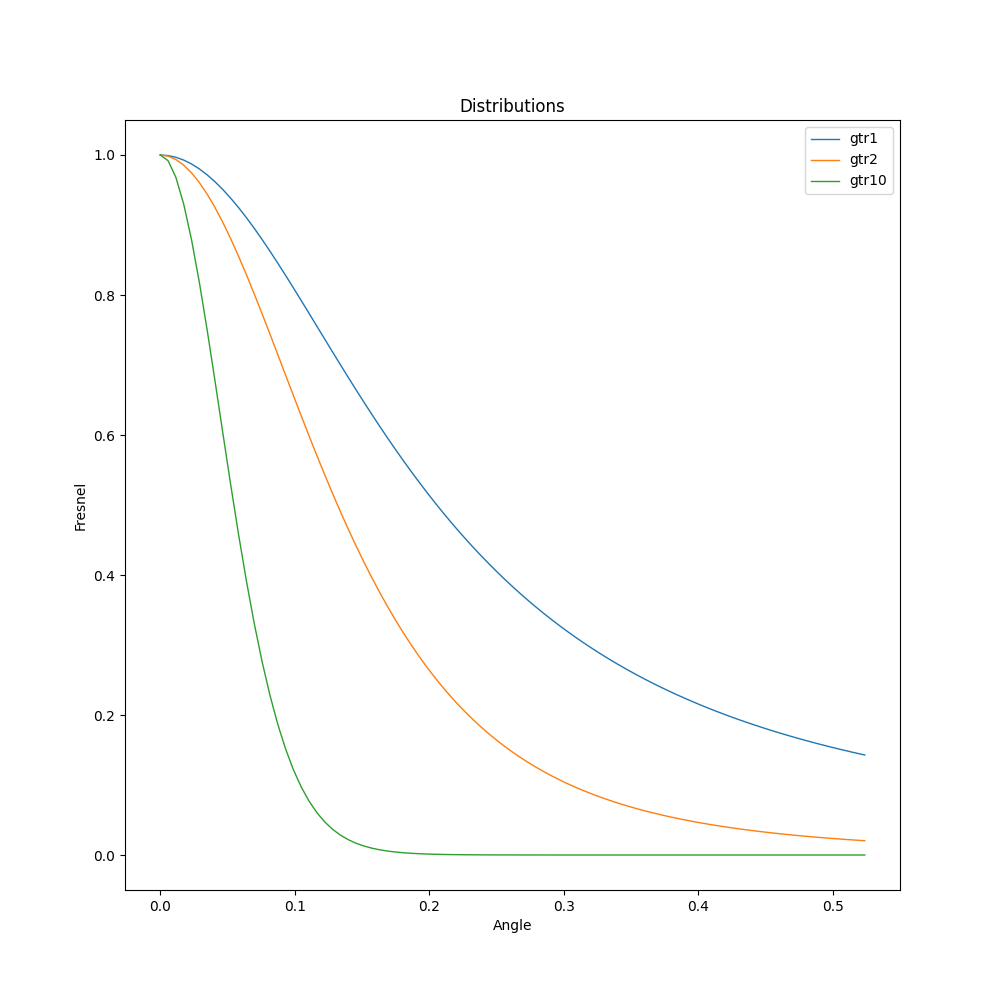

In [138]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(adjustable='box')
ax.set_title("Distributions")
ax.set_xlabel("Angle")
ax.set_ylabel("Fresnel")

for i in range(len(f)):
    ax.plot(x[0], f[i], linewidth=1, label=labels[i])

ax.legend()
ax.autoscale(enable=True, axis='x', tight=False)
ax.autoscale(enable=True, axis='y', tight=False)
plt.show()

In [139]:
def toSphereCoordinates(sinTheta: float, cosTheta: float, phi : float) -> tuple[float, float, float]:
	x: float = sinTheta * math.cos(phi)
	y: float = sinTheta * math.sin(phi)
	z: float = cosTheta
	return (x, y, z) 

In [140]:
def sampleGTR2(cosTheta:float, alpha: float, u: tuple[float, float]) -> tuple[float, float, float]:
	alpha2: float = alpha * alpha
	phi = (2 * math.pi) * u[0]
	cosTheta: float = math.sqrt((1.0 - u[1]) / (1.0 + (alpha2 - 1.0) * u[1])) 
	sinTheta: float = math.sqrt(max(0.0, 1.0 - cosTheta * cosTheta)) 
	return toSphereCoordinates(sinTheta, cosTheta, phi)

In [141]:
# list comprehension fill list with values
ALPHA_MIN = 1e-4
ALPHA_MAX = 1
ALPHA_MID = 0.5

thetasdeg = [i / 3 for i in range(0, int(math.degrees(math.pi / 2) + 1)) ]
thetas = [math.radians(i) for i in thetasdeg]

a1 = []
a2 = []
a3 = []
for n in range(100):
    a1 += [sampleGTR2(t, ALPHA_MIN, (random.random(),random.random())) for t in thetas]
    a2 += [sampleGTR2(t, ALPHA_MAX, (random.random(),random.random())) for t in thetas]
    a3 += [sampleGTR2(t, ALPHA_MID, (random.random(),random.random())) for t in thetas]

a1x, a1y, a1z = zip(*a1)
a2x, a2y, a2z = zip(*a2)
a3x, a3y, a3z = zip(*a3)

x = [a1x, a2x, a3x]
y = [a1y, a2y, a3y]
z = [a1z, a2z, a3z]
labels=["ALPHA_MIN", "ALPHA_MAX", "ALPHA_MID"]
colors = ["#fd084a", "#494fc1", "#a0fefb"]
size = [10, .1, .1]

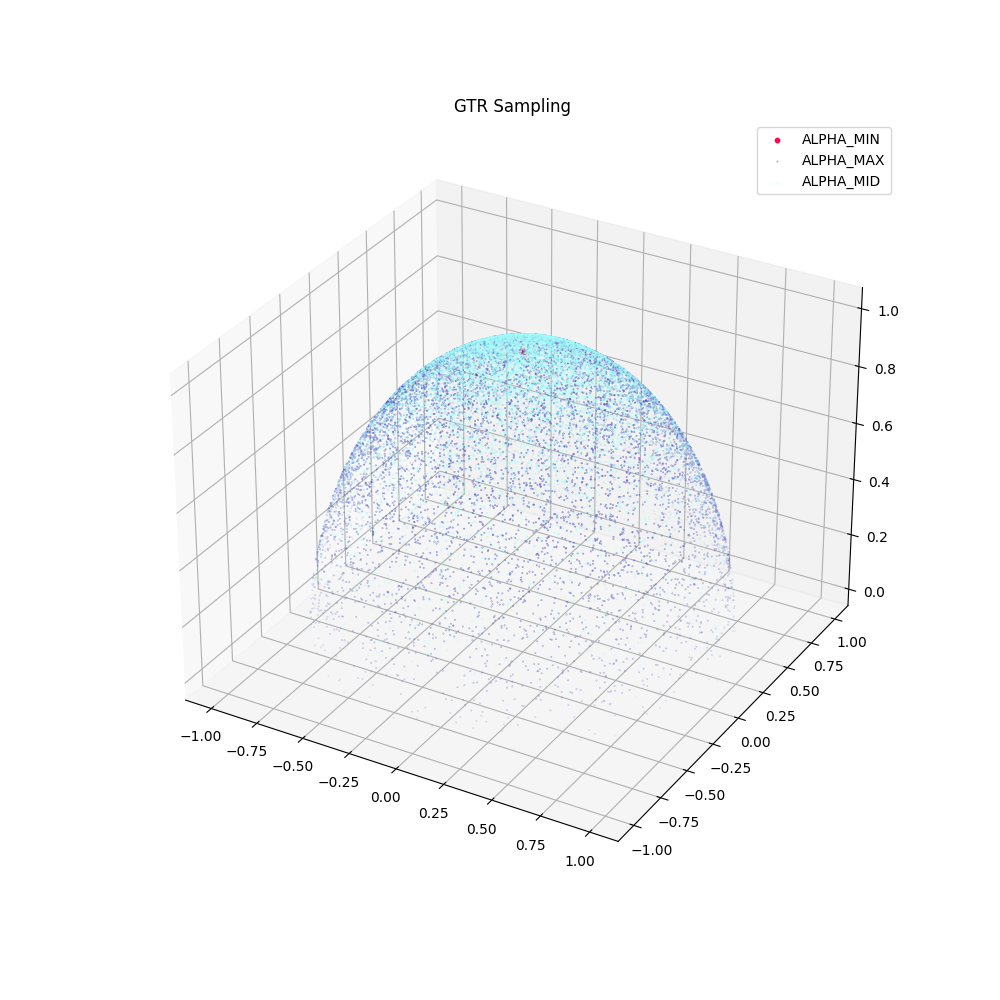

In [142]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')
ax.set_title("GTR Sampling")
ax.auto_scale_xyz(x, y, z, 'equal')

for i in range(len(x)):
    k = [p * size[i] for p in z[i]]
    ax.scatter(x[i], y[i], z[i], s=k, label=labels[i], color=colors[i])
    ax.legend()
    ax.autoscale(enable=True, axis='x', tight=False)
    ax.autoscale(enable=True, axis='y', tight=False)

plt.show()

# MASKING-SHADOWING FUNCTION

- Microfacet Models for Refraction through Rough Surfaces - Bruce Walter
- term is for single-scattering accurate and correct
- newer version which got adopted in 2014 revision
- **NOTE:** this term is not energy conserving for multi-scattering events

In [143]:
# lambda term which is modeling shadowing and masking
def lambd(thetaH: float, alpha: float) -> float:
    absTanThetaH: float = abs(math.tan(thetaH))
    if math.isinf(absTanThetaH):
        return 0
    alpha2Tan2Theta: float = (alpha * absTanThetaH) * (alpha * absTanThetaH)
    return (-1 + math.sqrt(1.0 + alpha2Tan2Theta)) / 2.0

In [144]:
# geometric term for a theta and alpha
def smithG(thetaH: float, alphaG: float) -> float:
    return 1 / (1 + lambd(thetaH, alphaG))

In [145]:
total = math.pi
offset = total / 2 

thetas = [math.radians(i - math.degrees(offset)) for i in range(0, int(math.degrees(total)))]

shadowing05 = [smithG(i, 0.05) for i in thetas]
shadowing25 = [smithG(i, 0.25) for i in thetas]
shadowing75 = [smithG(i, 0.75) for i in thetas]

x = [thetas]
f = [shadowing05, shadowing25, shadowing75]
labels=["a=0.05", "a=0.25", "a=0.75"]

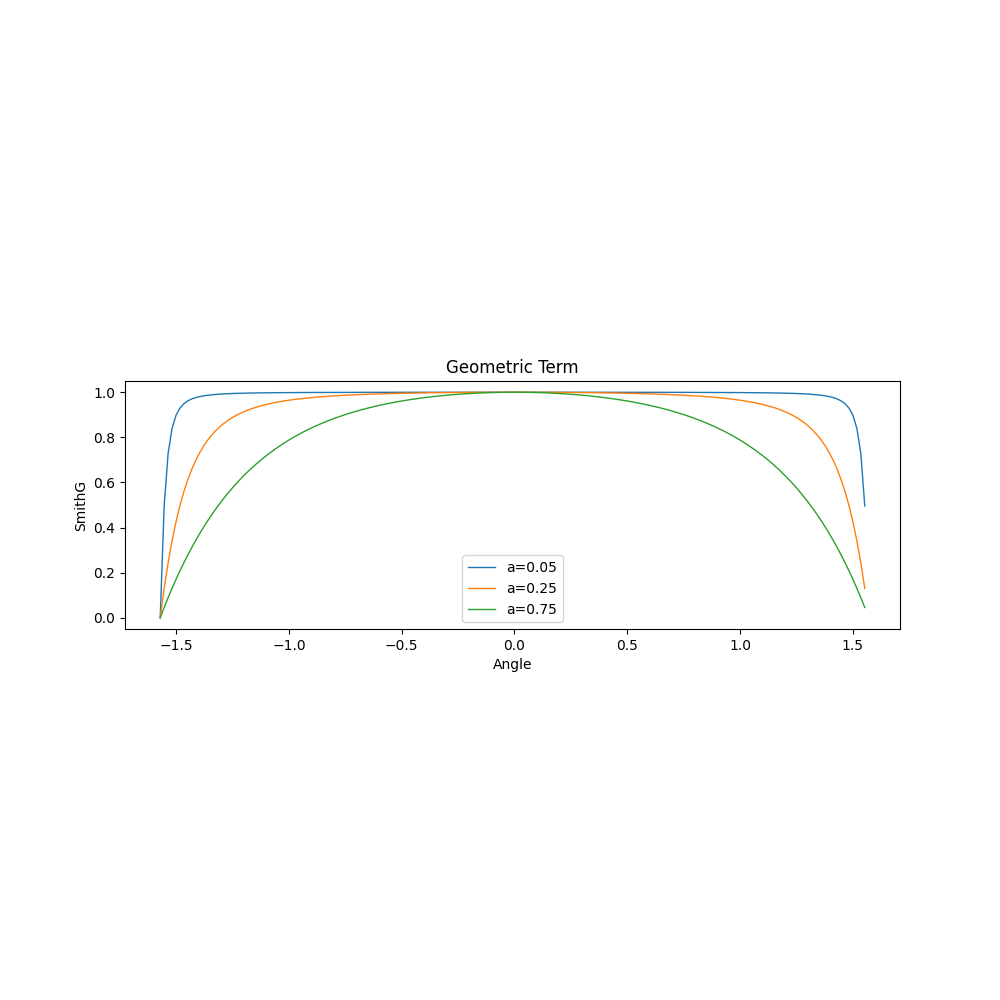

In [146]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(aspect='equal', adjustable='box')
ax.set_title("Geometric Term")
ax.set_xlabel("Angle")
ax.set_ylabel("SmithG")

for i in range(len(f)):
    ax.plot(x[0], f[i], linewidth=1, label=labels[i])

ax.legend()
ax.autoscale(enable=True, axis='x', tight=False)
ax.autoscale(enable=True, axis='y', tight=False)
plt.show()

# SAMPLING

## DISKS

In [147]:
def sampleConcentricDisk(u: tuple[float, float]) -> tuple[float, float]:
    dx = 2.0 * u[0] - 1.0
    dy = 2.0 * u[1] - 1.0

    if dx == 0 and dy == 0:
        return (0, 0)

    phi = 0
    r = 0

    if abs(dx) > abs(dy):
        r = dx
        phi = (math.pi / 4) * (dy / dx)
    else:
        r = dy
        phi = (math.pi / 2) - (dx / dy) * (math.pi / 4)
    
    return (r * math.cos(phi), r * math.sin(phi))

In [148]:
def sampleUniformDisk(u: tuple[float, float]) -> tuple[float, float]:
    phi = 2 * math.pi * u[1]
    r = math.sqrt(u[0])
    return (r * math.cos(phi), r * math.sin(phi))

In [149]:
samples = 10000
pointsUniform = []
pointsCosine = []

for i in range(0, samples):
    u = (random.random(), random.random())
    pointsUniform.append(sampleUniformDisk(u))
for i in range(0, samples):
    u = (random.random(), random.random())
    pointsCosine.append(sampleConcentricDisk(u))

ux, uy = zip(*pointsUniform)
cx, cy = zip(*pointsCosine)

x = [ux, cx]
y = [uy, cy]
labels=["Uniform", "Cosine"]

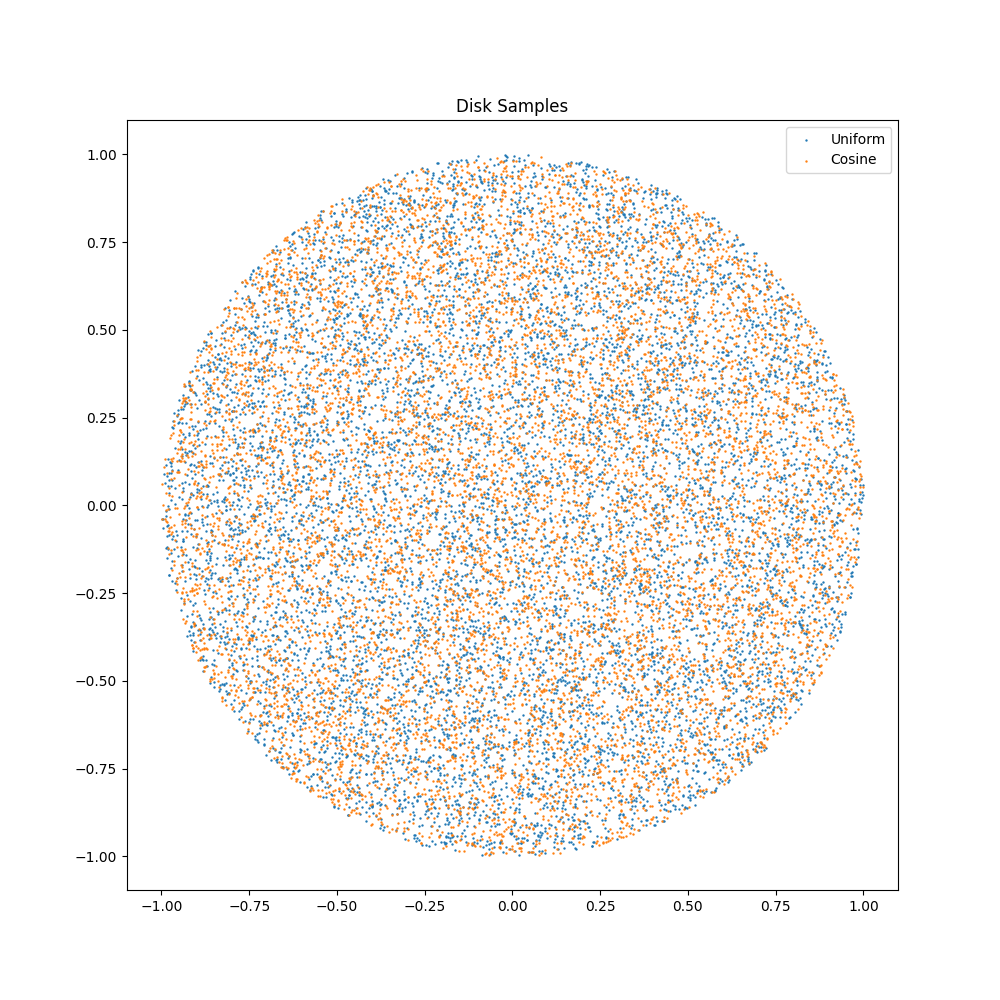

In [150]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(aspect='equal', adjustable='box')
ax.set_title("Disk Samples")

for i in range(len(y)):
    ax.scatter(x[i], y[i], s=.5, label=labels[i])

ax.legend()
ax.autoscale(enable=True, axis='x', tight=False)
ax.autoscale(enable=True, axis='y', tight=False)
plt.show()

## HEMISPHERES

In [151]:
def sampleUniformHemisphere(u: tuple[float, float]) -> tuple[float, float, float]:
    z = u[0]
    r = math.sqrt(max(0.0, 1.0 - z * z))
    phi = 2.0 * math.pi * u[1]
    x = r * math.cos(phi)
    y = r * math.sin(phi)
    return (x, y, z)

def pdfUniformHemisphere(p: tuple[float, float, float]) -> float:
    return 1.0 / (2.0 * math.pi)

In [152]:
def sampleCosineHemisphere(u: tuple[float, float]) -> tuple[float, float, float]:
    p = sampleConcentricDisk(u)
    costheta = math.sqrt(max(0.0, 1 - p[0] * p[0] - p[1] * p[1]))
    return (p[0], p[1], costheta)
    
def pdfCosineHemisphere(p: tuple[float, float, float]) -> float:
    return abs(p[2]) * (1.0 / math.pi)

In [153]:
samples = 10000
pointsUniform = []
pointsCosine = []

for i in range(0, samples):
    u = (random.random(), random.random())
    pointsUniform.append(sampleUniformHemisphere(u))
    pointsCosine.append(sampleCosineHemisphere(u))

ux, uy, uz = zip(*pointsUniform)
cx, cy, cz = zip(*pointsCosine)
updf = [pdfUniformHemisphere(i) for i in pointsUniform]
cpdf = [pdfCosineHemisphere(i) for i in pointsCosine]

x = [ux, cx]
y = [uy, cy]
z = [uz, cz]
pdf = [updf, cpdf]
labels=["Uniform", "Cosine"]


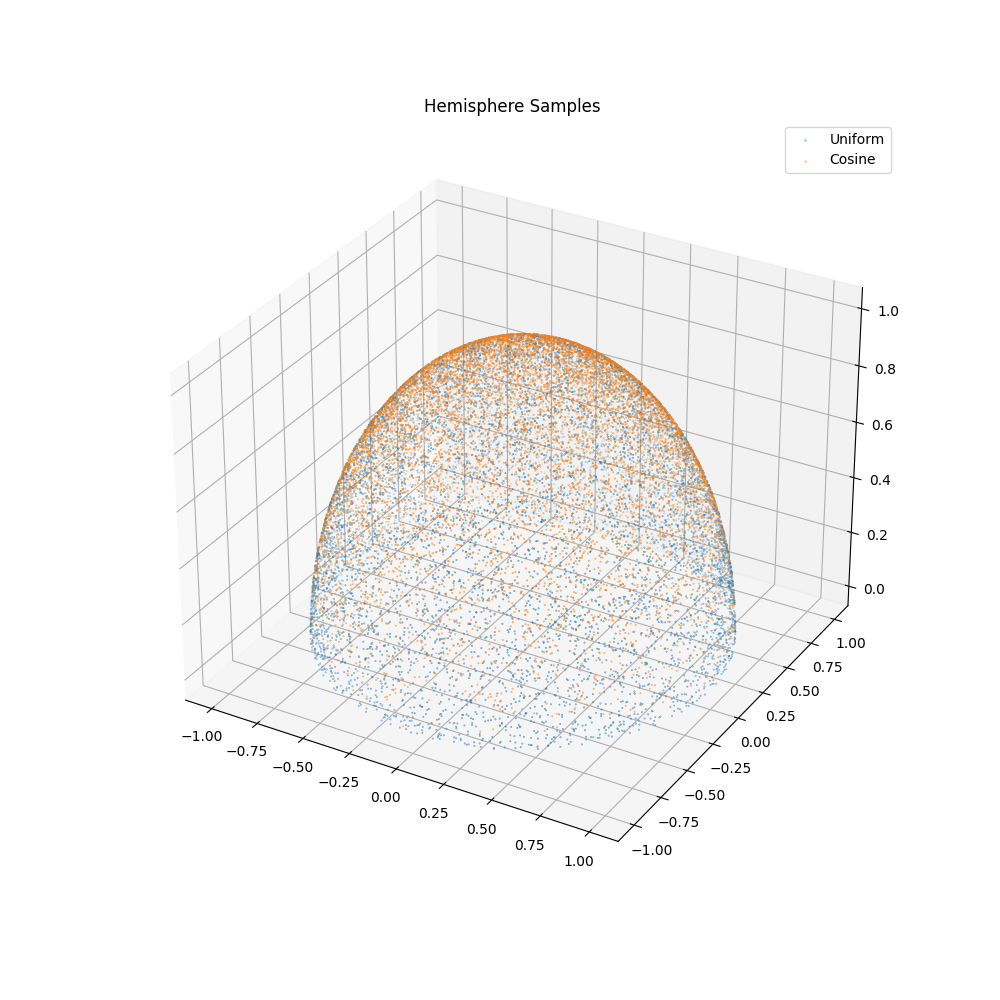

In [154]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection='3d')
ax.set_title("Hemisphere Samples")
ax.auto_scale_xyz(x, y, z, 'equal')

for i in range(len(y)):
    ax.scatter3D(x[i], y[i], z[i], s=.1, label=labels[i])
    ax.legend()
    ax.autoscale(enable=True, axis='x', tight=False)
    ax.autoscale(enable=True, axis='y', tight=False)

plt.show()

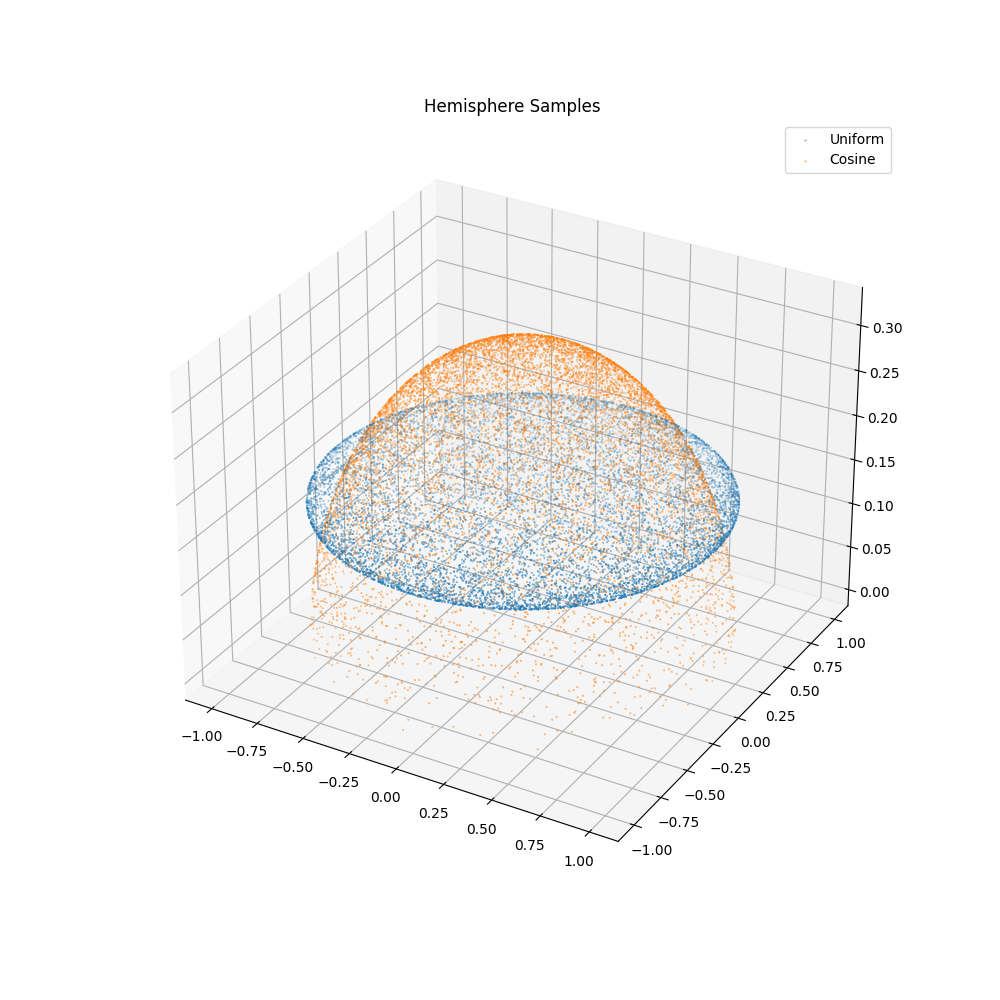

In [155]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title("Hemisphere Samples")
ax.auto_scale_xyz(x, y, z, 'equal')

for i in range(len(y)):
    ax.scatter(x[i], y[i], pdf[i], s=.1, label=labels[i])

ax.legend()
ax.autoscale(enable=True, axis='x', tight=False)
ax.autoscale(enable=True, axis='y', tight=False)
plt.show()